<a href="https://colab.research.google.com/github/bapronx/birth_analysis/blob/master/stats_naissances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etude sur la saisonnalité des naissances

## Obtention des données et import des librairies



In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from scipy.signal import filtfilt, butter, freqz


!wget https://www.insee.fr/fr/statistiques/fichier/3576462/T79jnais.xls

--2019-10-01 10:17:00--  https://www.insee.fr/fr/statistiques/fichier/3576462/T79jnais.xls
Resolving www.insee.fr (www.insee.fr)... 143.196.255.163, 194.254.37.163
Connecting to www.insee.fr (www.insee.fr)|143.196.255.163|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/vnd.ms-excel]
Saving to: ‘T79jnais.xls.3’

T79jnais.xls.3          [   <=>              ]   3.62M   482KB/s    in 8.1s    

2019-10-01 10:17:08 (456 KB/s) - ‘T79jnais.xls.3’ saved [3798016]



## Présentation des données et formatage des données

L'Insee nous met à disposition le nombre total de naissance en france, jour par jour de 1968 à 2017.

Nous allons explorer ce fichier pour caractériser les principaux facteurs d'influence sur ce nombre de naissance journalier.

In [47]:
fname = "T79jnais.xls"
df = pd.read_excel(fname, header=3, usecols=tuple(range(2,34)))
df2=(pd.read_excel(fname, header=4, usecols=(0,1)))
df.drop(0, inplace=True)
df.index = range(len(df))

df["annee"] = df2[df2.columns[0]][:-1]
df["mois"] = df2[df2.columns[1]][:-1]
df.head()

,Total du mois,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,annee,mois
0,70409.0,2080.0,2319.0,2335.0,2338.0,2319.0,2212.0,2083.0,2252.0,2261.0,2295.0,2233.0,2284.0,2168.0,2166.0,2366.0,2368.0,2331.0,2267.0,2286.0,2301.0,2139.0,2268.0,2290.0,2345.0,2254.0,2324.0,2303.0,2232.0,2335,2352,2303,1968,Janvier
1,67077.0,2327.0,2399.0,2228.0,2198.0,2391.0,2516.0,2398.0,2402.0,2515.0,2410.0,2189.0,2268.0,2359.0,2396.0,2392.0,2298.0,2204.0,2136.0,2299.0,2372.0,2290.0,2247.0,2286.0,2342.0,2081.0,2296.0,2272.0,2261.0,2305,so,so,NaN,Février
2,73703.0,2371.0,2385.0,2200.0,2394.0,2391.0,2416.0,2386.0,2352.0,2454.0,2235.0,2470.0,2389.0,2269.0,2399.0,2409.0,2477.0,2274.0,2391.0,2450.0,2442.0,2473.0,2355.0,2370.0,2174.0,2501.0,2441.0,2294.0,2356.0,2441,2456,2288,NaN,Mars
3,71719.0,2448.0,2361.0,2381.0,2370.0,2344.0,2454.0,2208.0,2344.0,2348.0,2344.0,2434.0,2414.0,2435.0,2275.0,2285.0,2516.0,2464.0,2399.0,2431.0,2502.0,2391.0,2518.0,2427.0,2358.0,2286.0,2356.0,2404.0,2268.0,2495,2459,so,NaN,Avril
4,75317.0,2409.0,2466.0,2421.0,2551.0,2303.0,2563.0,2447.0,2474.0,2428.0,2547.0,2478.0,2278.0,2499.0,2584.0,2537.0,2440.0,2410.0,2387.0,2250.0,2526.0,2384.0,2419.0,2301.0,2483.0,2364.0,2397.0,2377.0,2427.0,2470,2333,2364,NaN,Mai


Les données sont dans un tableau dont le format n'est pas des plus pratique. Nous allons le reformater comme une time series, en étiquetant à chaque fois le jour de la semaine et le mois.


In [3]:
naissance_array = df[df.columns[1:32]].apply(lambda x: pd.to_numeric(x, errors='coerce'))
naissance_array = naissance_array.to_numpy().ravel()
sel = 1-(np.isnan(naissance_array))
naissance_array = naissance_array[sel==1]
date = pd.date_range(start='1/1/1968', freq='D', periods=len(naissance_array))
dated_df = pd.DataFrame(naissance_array, index=date, columns=["nb_naissance"])
month_names = ["janvier", "fevrier", "mars", "avril",
               "mai", "juin", "juillet", "aout",
               "septembre", "octobre", "novembre", "decembre"]
day_names = ["lundi", "mardi", "mercredi",
             "jeudi", "vendredi", "samedi", "dimanche"]
dated_df["mois"] = date.map(lambda x: month_names[x.month-1])
dated_df["jour_de_la_semaine"] = date.map(lambda x: day_names[x.dayofweek])
dated_df["annee"] = date.map(lambda x: x.year)
dated_df.head(3)

,nb_naissance,mois,jour_de_la_semaine,annee
1968-01-01,2080.0,janvier,lundi,1968
1968-01-02,2319.0,janvier,mardi,1968
1968-01-03,2335.0,janvier,mercredi,1968


Pour certains, la lune influence les naissances.
Essayons donc d'étiquetter aussi le cylcle lunaire

In [4]:
def moon_phase(date):
    month, day, year = date.month, date.day, date.year
    ages = [18, 0, 11, 22, 3, 14, 25, 6, 17, 28, 9, 20, 1, 12, 23, 4, 15, 26, 7]
    offsets = [-1, 1, 0, 1, 2, 3, 4, 5, 7, 7, 9, 9]
    description = ["new (totally dark)",
      "waxing crescent (increasing to full)",
      "in its first quarter (increasing to full)",
      "waxing gibbous (increasing to full)",
      "full (full light)",
      "waning gibbous (decreasing from full)",
      "in its last quarter (decreasing from full)",
      "waning crescent (decreasing from full)"]
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    if day == 31:
        day = 1
    days_into_phase = ((ages[(year + 1) % 19] +
                        ((day + offsets[month-1]) % 30) +
                        (year < 1900)) % 30)
    index = int((days_into_phase + 2) * 16/59.0)
    if index > 7:
        index = 7
    status = description[index]
    # light should be 100% 15 days into phase
    light = int(2 * days_into_phase * 100/29)
    if light > 100:
        light = abs(light - 200);
    date = "%d%s%d" % (day, months[month-1], year)
    return date, status, light

def isfullmoon(date):
	_, status, _ = moon_phase(date)
	return status == "full (full light)"

dated_df["moonlight"] = date.map(lambda x:moon_phase(x)[2])
dated_df["moonlight_descr"] = date.map(lambda x:moon_phase(x)[1])
dated_df.head(15)

,nb_naissance,mois,jour_de_la_semaine,annee,moonlight,moonlight_descr
1968-01-01,2080.0,janvier,lundi,1968,6,new (totally dark)
1968-01-02,2319.0,janvier,mardi,1968,13,waxing crescent (increasing to full)
1968-01-03,2335.0,janvier,mercredi,1968,20,waxing crescent (increasing to full)
1968-01-04,2338.0,janvier,jeudi,1968,27,waxing crescent (increasing to full)
1968-01-05,2319.0,janvier,vendredi,1968,34,waxing crescent (increasing to full)
1968-01-06,2212.0,janvier,samedi,1968,41,in its first quarter (increasing to full)
1968-01-07,2083.0,janvier,dimanche,1968,48,in its first quarter (increasing to full)
1968-01-08,2252.0,janvier,lundi,1968,55,in its first quarter (increasing to full)
1968-01-09,2261.0,janvier,mardi,1968,62,in its first quarter (increasing to full)
1968-01-10,2295.0,janvier,mercredi,1968,68,waxing gibbous (increasing to full)


On peut sortir quelques graphiques pour visualiser nos données sur différentes échelles de temps:

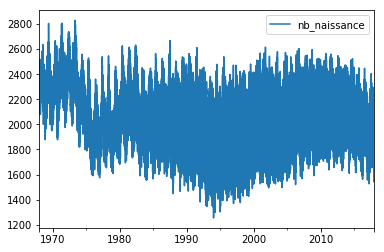

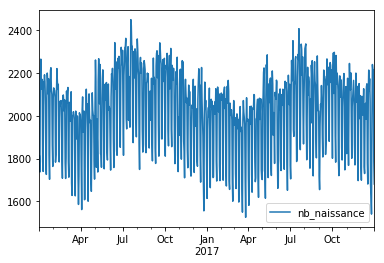

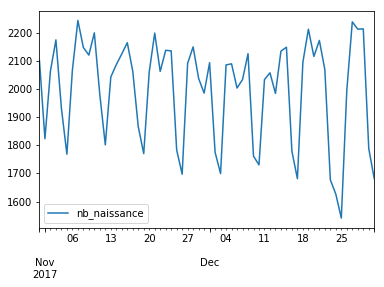

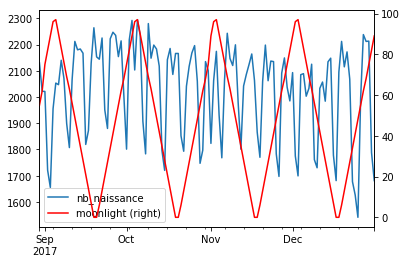

In [5]:
dated_df.plot(y="nb_naissance")
dated_df.iloc[-365*2:,:].plot(y="nb_naissance")
dated_df.iloc[-31*2:,:].plot(y="nb_naissance")

fig, ax = plt.subplots()
dated_df.iloc[-31*4:,:].plot(ax=ax,y="nb_naissance")
dated_df.iloc[-31*4:,:].plot(ax=ax,y="moonlight",secondary_y=True, style='r-')

On peut noter visuellement plusieurs points:

1.   Un effet "week end" clair
2.   Un cycle annuel asymétrique avec un maximum vers l'été et un miminum vers avril
3.   Une tendance long terme (pluriannuelle) complexe représentant les évolutions démographiques conjoncturelles
4.   Visuellement, l'effet lunaire n'est pas très probant

Pour aller plus loin, on va enlever la tendance pluriannuelle à l'aide d'un filtre passe haut


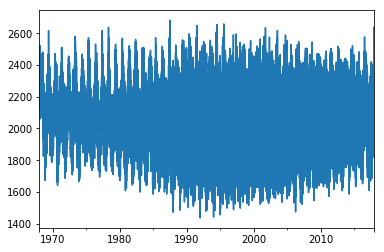

In [6]:
b, a = butter(4, 1./365, 'high')
dated_df["nb_naissance_detrend"] = dated_df["nb_naissance"] - dated_df["nb_naissance"].mean()
dated_df["nb_naissance_detrend"] = filtfilt(b,a,dated_df["nb_naissance_detrend"]) + dated_df["nb_naissance"].mean()
dated_df["nb_naissance_detrend"].plot()


## Facteurs d'influence sur le nombre de naissance

On peut déjà regarder le nombre de naissance en fonction du cycle lunaire

Text(0.5, 1.0, 'Nombre de naissance par jour')

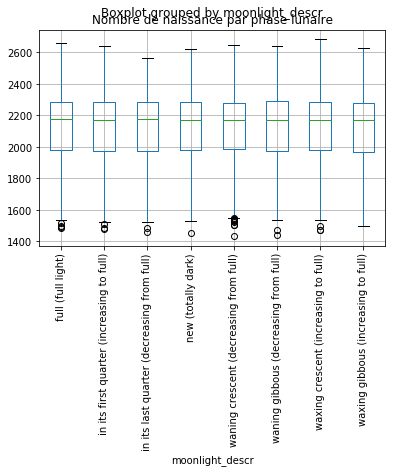

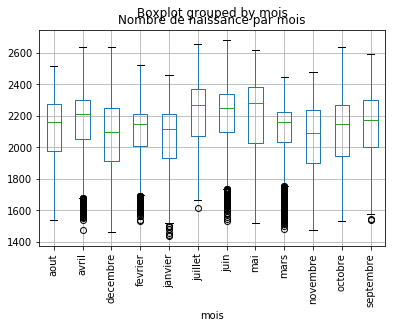

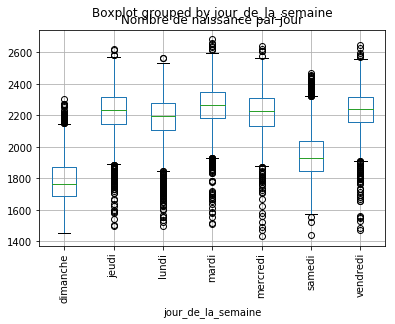

In [7]:

dated_df.boxplot(by="moonlight_descr", column="nb_naissance_detrend", rot=90)
plt.title("Nombre de naissance par phase lunaire")

dated_df.boxplot(by="mois", column="nb_naissance_detrend", rot=90)
plt.title("Nombre de naissance par mois")

dated_df.boxplot(by="jour_de_la_semaine", column="nb_naissance_detrend", rot=90)
plt.title("Nombre de naissance par jour")


On retombe sur les même conclusions: effet du jour et du mois, mais pas de la lune. Par contre, il semble que le minimum des mois n'est pas en avril mais plutot vers decembre.

Il faut maintenant vérifier nos intuitions via un modèle linéaire.
Pour cela, on met les jours et les mois en facteurs et on fait une régression.

In [8]:
aa=pd.concat((dated_df, pd.get_dummies(dated_df["mois"], drop_first=True)), axis=1)
aa=pd.concat((aa, pd.get_dummies(dated_df["jour_de_la_semaine"], drop_first=True)), axis=1)
aa.head(2)

,nb_naissance,mois,jour_de_la_semaine,annee,moonlight,moonlight_descr,nb_naissance_detrend,avril,decembre,fevrier,janvier,juillet,juin,mai,mars,novembre,octobre,septembre,jeudi,lundi,mardi,mercredi,samedi,vendredi
1968-01-01,2080.0,janvier,lundi,1968,6,new (totally dark),2137.496064,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1968-01-02,2319.0,janvier,mardi,1968,13,waxing crescent (increasing to full),2375.070184,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


nb_naissance_detrend ~ avril + decembre + fevrier + janvier + juillet + juin + mai + mars + novembre + octobre + septembre + jeudi + lundi + mardi + mercredi + samedi + vendredi + moonlight
                             OLS Regression Results                             
Dep. Variable:     nb_naissance_detrend   R-squared:                       0.628
Model:                              OLS   Adj. R-squared:                  0.628
Method:                   Least Squares   F-statistic:                     1712.
Date:                  Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                          10:17:15   Log-Likelihood:            -1.1522e+05
No. Observations:                 18263   AIC:                         2.305e+05
Df Residuals:                     18244   BIC:                         2.306e+05
Df Model:                            18                                         
Covariance Type:              nonrobust                                         


Text(0.5, 1.0, 'histogramme des résidus')

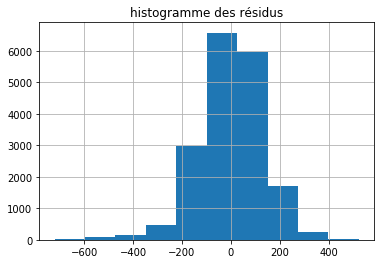

In [9]:
day_names.sort()
month_names.sort()
formula = "nb_naissance_detrend ~ "
for m in month_names[1:]:
  formula = formula + "{} + ".format(m)
for d in day_names[1:]:
  formula = formula + "{} + ".format(d)
formula = formula + "moonlight"
test_regression = smf.ols(formula, data=aa).fit()
print(formula)
print(test_regression.summary())

test_regression.resid.hist()
plt.title("histogramme des résidus")

Avec un p-value à 25%, on rejète effectivement l'hypothèse que la lune influence le nombre de naissance.

Totues les autres p-value étant < 0.01, on peut les considérer comme facteurs d'influence. Aussi, on peut sortir un ranking de ces facteurs d'influences.

Ci-dessous, les jours sont comparés au dimanche, et les mois sont comparés à août.

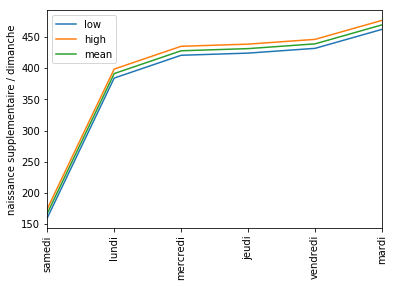

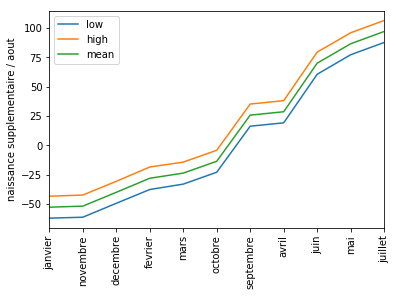

In [46]:
factors = test_regression.params
factors.drop(index=["Intercept", "moonlight"], inplace=True)
factors.sort_values(ascending=False)

confint = test_regression.conf_int().drop(index=["Intercept", "moonlight"])
confint = confint.rename(columns = {0:"low", 1:"high"})
confint = pd.concat((confint,factors), axis=1)
confint = confint.rename(columns = {0:"mean"})
confint.sort_values("mean", inplace=True)

ax=confint.iloc[11:].plot()
ax.set_ylabel("naissance supplementaire / dimanche")
ax.set_xticks(range(6));
ax.set_xticklabels(["%s" % item for item in confint.index[11:]], rotation=90);

ax2=confint.iloc[:11].plot()
ax2.set_ylabel("naissance supplementaire / aout")
ax2.set_xticks(range(11));
ax2.set_xticklabels(["%s" % item for item in confint.index[:11]], rotation=90);

Outre les variations saisonnières et l'effet week-end, on peut noter que si mercredi, jeudi et vendredi sont équivalents, il semble y avoir un léger report de naissances de lundi à mardi, avec un "creux" le lundi et un "pic" le mardi, de presque 50 naissances en moyenne.